In [123]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
% matplotlib inline

import nengo
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import norm_spa_vecs

import glob
from collections import namedtuple

In [4]:
def numpy_bytes_to_str(lst):
    return [l.decode('utf-8') for l in lst]

In [5]:
with h5py.File("../data/meg_ia_full.h5py", "r") as fi:
    print(list(fi.keys()))
    inp = np.array(fi['input'])
    #output = np.array(fi['output'])
    
    fan1 = numpy_bytes_to_str(fi['fan1'])
    fan2 = numpy_bytes_to_str(fi['fan2'])
    foil1 = numpy_bytes_to_str(fi['foil1'])
    foil2 = numpy_bytes_to_str(fi['foil2'])
    
    v_strs = numpy_bytes_to_str(fi['vocab_strings'])
    v_vecs = list(fi['vocab_vectors'])
    D = fi['vocab_vectors'].attrs['dimensions']
    
    #accum = np.array(fi['accum'])
    clean = np.array(fi['clean'])
    clean_accum = np.array(fi['clean_accum'])
    #de_out = np.array(fi['de_out'])

    dt = fi['t_range'].attrs['dt']
    t_range = np.arange(fi['t_range'][0], fi['t_range'][1], dt)
    t_pause = fi['t_range'].attrs['t_pause']
    t_present = fi['t_range'].attrs['t_present']

['clean', 'clean_accum', 'correct', 'fan1', 'fan2', 'foil1', 'foil2', 'input', 't_range', 'vocab_strings', 'vocab_vectors']


In [32]:
t_each = t_pause + t_present

td_each = int(t_each/dt)
td_pause = int(t_pause/dt)
td_present = int(t_present/dt)

In [7]:
vocab = spa.Vocabulary(D)
for val, vec in zip(v_strs, v_vecs):
    vocab.add(val, vec)

In [8]:
fan1_pair_vecs = norm_spa_vecs(vocab, fan1)
fan2_pair_vecs = norm_spa_vecs(vocab, fan2)
foil1_pair_vecs = norm_spa_vecs(vocab, foil1)
foil2_pair_vecs = norm_spa_vecs(vocab, foil2)

In [9]:
fan1_win = slice(int(t_pause / dt), int((len(fan1) * t_each + t_pause) / dt))
fan2_win = slice(fan1_win.stop, fan1_win.stop + int((len(fan2) * t_each) / dt))
foil1_win = slice(fan2_win.stop, fan2_win.stop + int((len(foil1) * t_each) / dt))
foil2_win = slice(foil1_win.stop, foil1_win.stop + int((len(foil2) * t_each) / dt  - dt))

wins = (fan1_win, fan2_win, foil1_win, foil2_win)

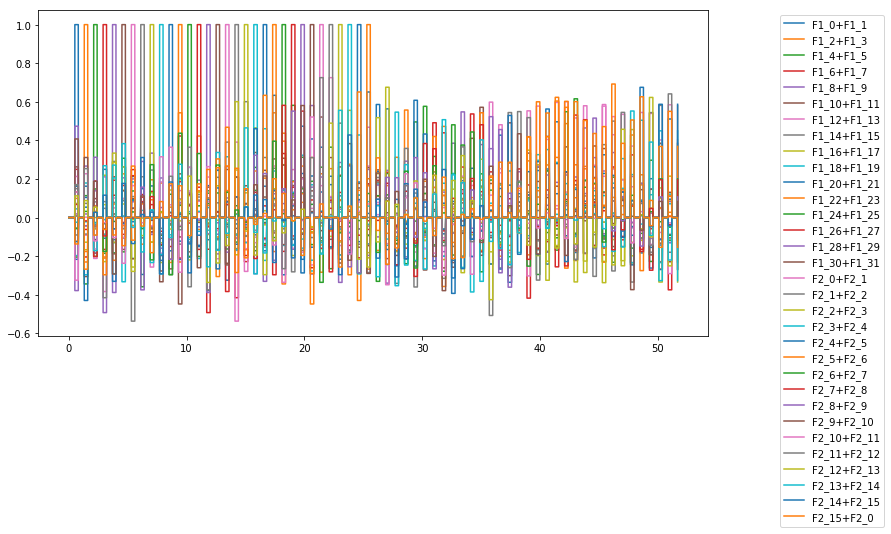

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(t_range, spa.similarity(inp, fan1_pair_vecs+fan2_pair_vecs))
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

(51700, 32)


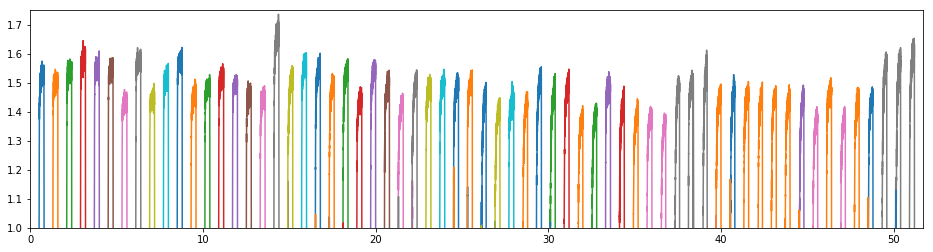

In [11]:
plt.figure(figsize=(16, 4))
plt.plot(t_range, clean_accum)
plt.ylim(1.0, 1.75)
plt.xlim(0, t_range[-1])
print(clean_accum.shape)

(0, 51.699)

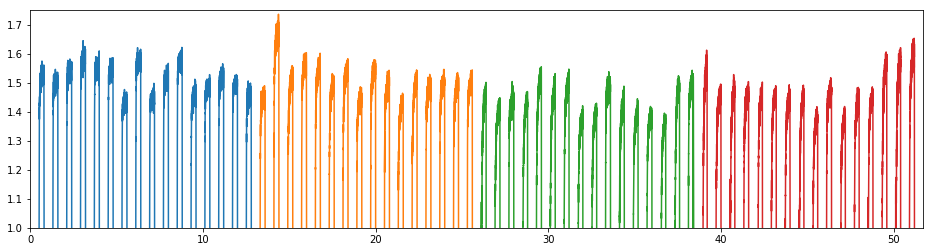

In [12]:
clean_max = np.max(clean_accum, axis=1)
plt.figure(figsize=(16, 4))
for win in wins:
    plt.plot(t_range[win], clean_max[win])
plt.ylim(1.0, 1.75)
plt.xlim(0, t_range[-1])

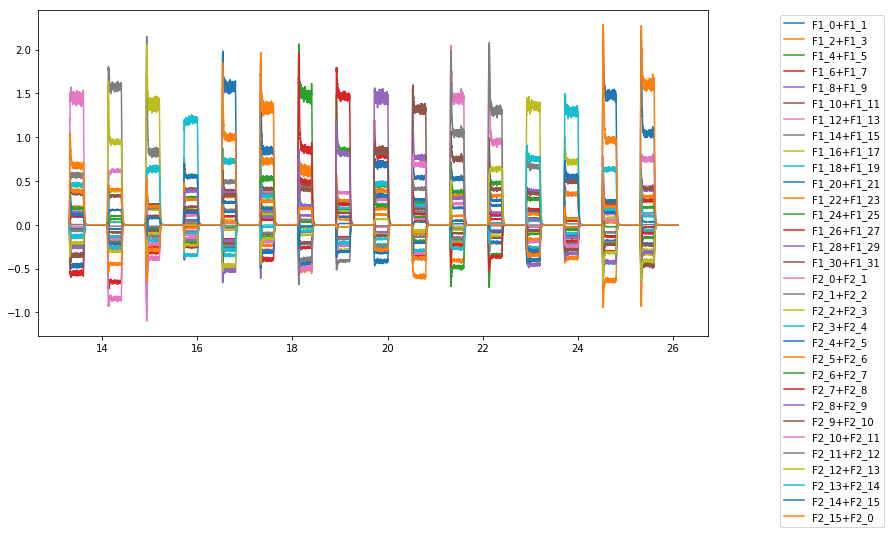

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(t_range[fan2_win], spa.similarity(clean, fan1_pair_vecs+fan2_pair_vecs)[fan2_win])
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

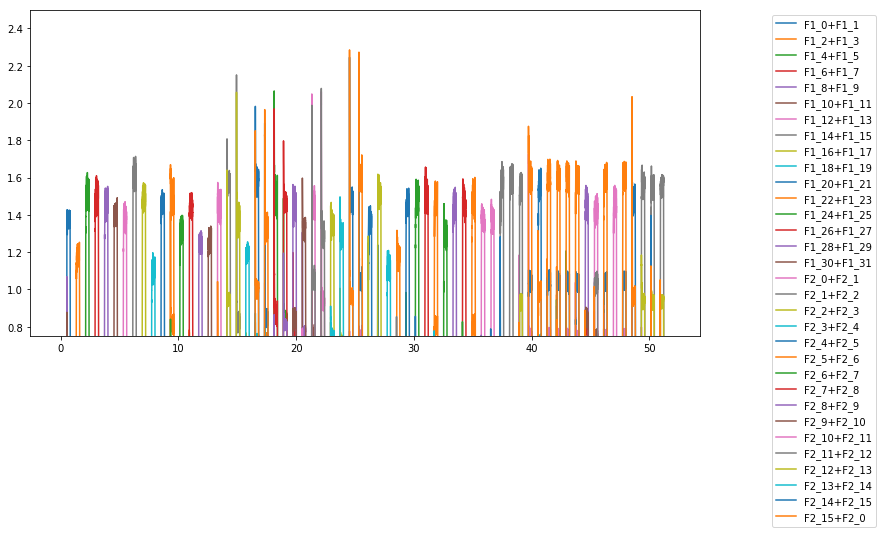

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(t_range, spa.similarity(clean, fan1_pair_vecs+fan2_pair_vecs))
plt.ylim(0.75, 2.5)
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

# Reaction Time and Error Rate

- FAN1 should be faster than FAN2. Should be minimal difference between FAN and FOIL, but FOIL does take a little longer.
- FAN1 should be more accurate than FAN2. Should be no difference between FAN and FOIL.

In [63]:
with h5py.File("../data/meg_ia_full_react.h5py", "r") as fi:
    clean_out = np.array(fi['clean_out'])

In [20]:
offset = 0.15

fan1_peak_idx = np.arange(fan1_win.start+int(offset/dt), fan1_win.stop, int(t_each/dt))
fan2_peak_idx = np.arange(fan2_win.start+int(offset/dt), fan2_win.stop, int(t_each/dt))
foil1_peak_idx = np.arange(foil1_win.start+int(offset/dt), foil1_win.stop, int(t_each/dt))
foil2_peak_idx = np.arange(foil2_win.start+int(offset/dt), foil2_win.stop, int(t_each/dt))

peak_indices = (fan1_peak_idx, fan2_peak_idx, foil1_peak_idx, foil2_peak_idx)

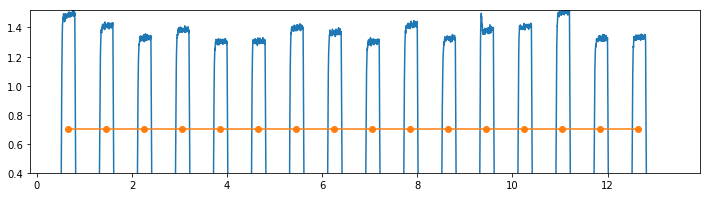

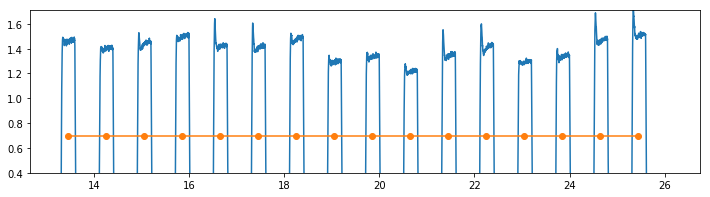

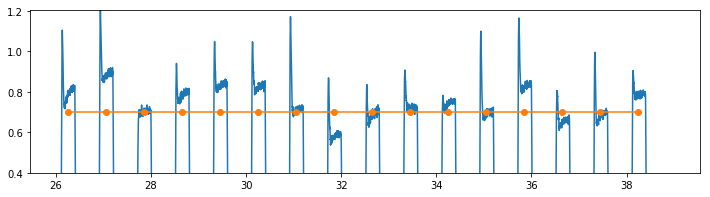

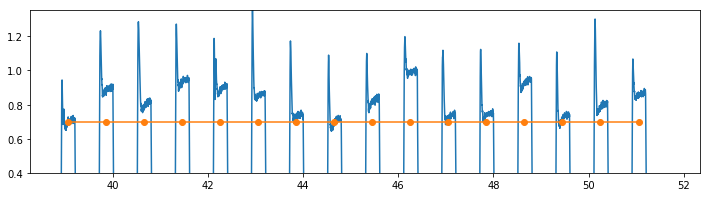

In [21]:
for win, peak_idx in zip(wins, peak_indices):
    plt.figure(figsize=(12, 3))
    plt.plot(t_range[win], clean_out[win])
    peaks = t_range[peak_idx]
    plt.plot(peaks, np.ones(peaks.shape)*0.7, linestyle=None, marker='o')
    plt.ylim(0.4, np.max(clean_out[win]))

1.3705241616846129
1.392866649070743
0.741347122365337
0.8137769765315279


(0.4, 1.5)

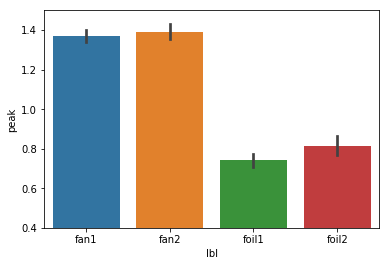

In [22]:
labels = ("fan1", "fan2", "foil1", "foil2")

pk_list = []
peak_lbl = []
for lbl, idx in zip(labels, peak_indices):
    print(np.mean(clean_out[idx]))
    pk_list.append(clean_out[idx])
    peak_lbl.extend([lbl] * len(idx))

all_peaks = np.concatenate(pk_list, axis=0).flatten()

pd_peak = pd.DataFrame({"peak": all_peaks, "lbl": peak_lbl})
ax = sns.barplot(x="lbl", y="peak", data=pd_peak)
ax.set_ylim((0.4, 1.5))

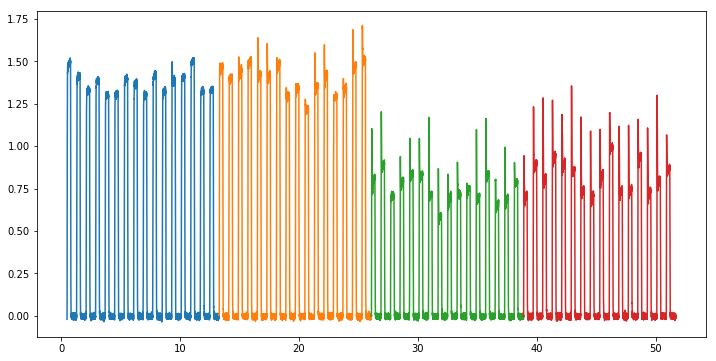

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(t_range[fan1_win], clean_out[fan1_win])
plt.plot(t_range[fan2_win], clean_out[fan2_win])
plt.plot(t_range[foil1_win], clean_out[foil1_win])
plt.plot(t_range[foil2_win.start:foil2_win.stop], clean_out[foil2_win])

In [24]:
with h5py.File("../data/meg_ia_full_react_noise.h5py", "r") as fi:
    clean_out = np.array(fi['clean_out'])

1.3726990126617404
1.3433471370654968
0.7390722475024899
0.8374485282994544


(0.4, 1.5)

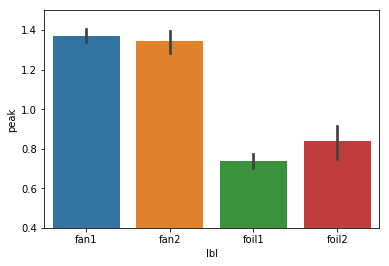

In [25]:
labels = ("fan1", "fan2", "foil1", "foil2")

pk_list = []
peak_lbl = []
for lbl, idx in zip(labels, peak_indices):
    print(np.mean(clean_out[idx]))
    pk_list.append(clean_out[idx])
    peak_lbl.extend([lbl] * len(idx))

all_peaks = np.concatenate(pk_list, axis=0).flatten()

pd_peak = pd.DataFrame({"peak": all_peaks, "lbl": peak_lbl})
ax = sns.barplot(x="lbl", y="peak", data=pd_peak)
ax.set_ylim((0.4, 1.5))

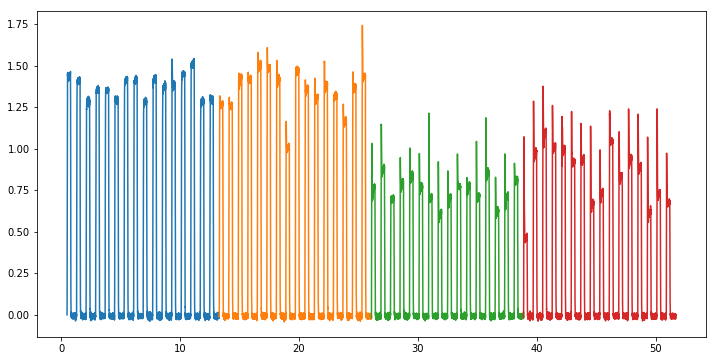

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(t_range[fan1_win], clean_out[fan1_win])
plt.plot(t_range[fan2_win], clean_out[fan2_win])
plt.plot(t_range[foil1_win], clean_out[foil1_win])
plt.plot(t_range[foil2_win.start:foil2_win.stop], clean_out[foil2_win])

In [27]:
with h5py.File("../data/meg_ia_full_react_red_noise.h5py", "r") as fi:
    clean_out = np.array(fi['clean_out'])

1.3709740799921242
1.141952562046848
0.7466823423560511
0.6421200821808902


(0.4, 1.5)

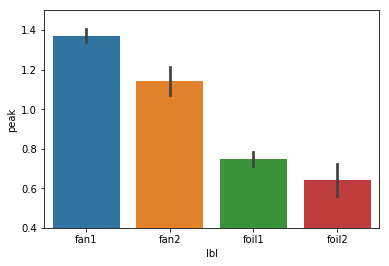

In [28]:
labels = ("fan1", "fan2", "foil1", "foil2")

pk_list = []
peak_lbl = []
for lbl, idx in zip(labels, peak_indices):
    print(np.mean(clean_out[idx]))
    pk_list.append(clean_out[idx])
    peak_lbl.extend([lbl] * len(idx))

all_peaks = np.concatenate(pk_list, axis=0).flatten()

pd_peak = pd.DataFrame({"peak": all_peaks, "lbl": peak_lbl})
ax = sns.barplot(x="lbl", y="peak", data=pd_peak)
ax.set_ylim((0.4, 1.5))

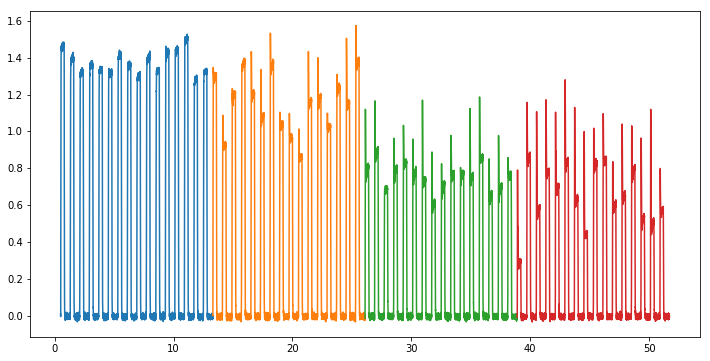

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(t_range[fan1_win], clean_out[fan1_win])
plt.plot(t_range[fan2_win], clean_out[fan2_win])
plt.plot(t_range[foil1_win], clean_out[foil1_win])
plt.plot(t_range[foil2_win.start:foil2_win.stop], clean_out[foil2_win])

In [203]:
def decision(match_output: np.ndarray, thresh=1.0, dec_thresh=1.0, thresh_adjust=False, plt_debug=False):
    below_thresh = match_output.copy()
    if thresh_adjust:
        below_thresh[below_thresh > thresh] = thresh
    below_diff = thresh - below_thresh
    cum_below = np.cumsum(below_diff)/100
    
    above_thresh = match_output.copy()
    if thresh_adjust:
        above_thresh[above_thresh < thresh] = thresh
    above_diff = above_thresh - thresh
    cum_above = np.cumsum(above_diff)/100
    
    above_cross = np.argmax(cum_above > dec_thresh)
    below_cross = np.argmax(cum_below > dec_thresh)
    b_crossed = (below_cross == 0 and cum_below[0] > dec_thresh) or below_cross > 0
    a_crossed = (above_cross == 0 and cum_above[0] > dec_thresh) or above_cross > 0
    
    if a_crossed and b_crossed:
        if above_cross < below_cross:
            dec_time = above_cross
            dec = 1
        elif below_cross < above_cross:
            dec_time = below_cross
            dec = -1
    elif a_crossed and not b_crossed:
        dec_time = above_cross
        dec = 1
    elif b_crossed and not a_crossed:
        dec_time = below_cross
        dec = -1
    elif not (below_cross or above_cross):
        dec_time = len(match_output)
        if cum_below[-1] > cum_above[-1]:
            dec = -1
        elif cum_above[-1] > cum_below[-1]:
            dec = 1
        else:
            dec = 0
            
    else:
        print("OMG WTF. IT WAS SUPPOSED TO BE TWO BOOLEANS.")
        dec_time = 0
        dec = 0
    
    if plt_debug:
        plt.figure()
        plt.plot(match_output, linestyle=":", label="orig")
        plt.plot(cum_above, label="above")
        plt.plot(cum_below, label="below")
        plt.legend()
        
    
    return dec_time, dec

In [204]:
all_time_slices = list(range(0, int((t_range[-1])/dt), int(t_each/dt)))[:-1]
len(all_time_slices)

64

In [205]:
match_labels = ["fan1"] * len(fan1) + ["fan2"] * len(fan2) + ["foil1"] * len(foil1) + ["foil2"] * len(foil2)
match_correct = [1] * (len(fan1) + len(fan2)) + [-1] * (len(fan1) + len(fan2))

In [206]:
fi_names = {"red_noise": "meg_ia_full_react_red_noise", "noise": "meg_ia_full_react_noise", "normal": "meg_ia_full_react"}

thresh = 1.0
dec_thresh = 0.5

In [207]:
df_list = []
err_list = []

for nm, fi in fi_names.items():
    with h5py.File(f"../data/{fi}.h5py", "r") as fi:
        clean_out = np.array(fi['clean_out'])
    
    decs = []
    t_decs = []

    for t_slice in all_time_slices:
        cl_slc = clean_out[t_slice+td_pause:t_slice+td_each]
        tm, dec = decision(cl_slc, thresh=thresh, dec_thresh=dec_thresh)
        decs.append(dec)
        t_decs.append(tm)

    decs = np.array(decs)
    t_decs = np.array(t_decs)
    run_name = [nm] * len(decs)
    df_list.append(pd.DataFrame.from_dict({"decs": decs, "t_decs": t_decs, "lbl": match_labels, "cor": match_correct, "run": run_name}))
    
    last_idx = 0
    for lst, lbl in zip((fan1, fan2, foil1, foil2), ("fan1", "fan2", "foil1", "foil2")):
        comp_slc = slice(last_idx, last_idx+len(lst))
        err_list.append((nm, np.sum(decs[comp_slc] != match_correct[comp_slc]), lbl))
        last_idx += len(lst)

df_match = pd.concat(df_list)
df_err = pd.DataFrame(err_list, columns=("run", "err", "lbl"))

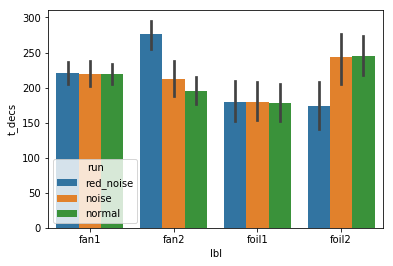

In [208]:
sns.barplot(x="lbl", y="t_decs", hue="run", data=df_match)

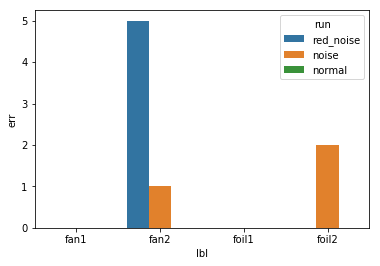

In [209]:
sns.barplot(x="lbl", y="err", hue="run", data=df_err)

In [210]:
df_list = []
err_list = []

for nm, fi in fi_names.items():
    with h5py.File(f"../data/{fi}.h5py", "r") as fi:
        clean_out = np.array(fi['clean_out'])
    
    decs = []
    t_decs = []

    for t_slice in all_time_slices:
        cl_slc = clean_out[t_slice+td_pause:t_slice+td_each]
        tm, dec = decision(cl_slc, thresh=thresh, dec_thresh=dec_thresh, thresh_adjust=False)
        decs.append(dec)
        t_decs.append(tm)

    decs = np.array(decs)
    t_decs = np.array(t_decs)
    run_name = [nm] * len(decs)
    df_list.append(pd.DataFrame.from_dict({"decs": decs, "t_decs": t_decs, "lbl": match_labels, "cor": match_correct, "run": run_name}))
    
    last_idx = 0
    for lst, lbl in zip((fan1, fan2, foil1, foil2), ("fan1", "fan2", "foil1", "foil2")):
        comp_slc = slice(last_idx, last_idx+len(lst))
        err_list.append((nm, np.sum(decs[comp_slc] != match_correct[comp_slc]), lbl))
        last_idx += len(lst)

df_match = pd.concat(df_list)
df_err = pd.DataFrame(err_list, columns=("run", "err", "lbl"))

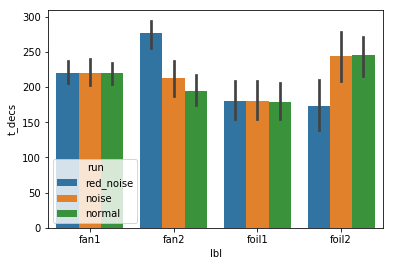

In [211]:
sns.barplot(x="lbl", y="t_decs", hue="run", data=df_match)

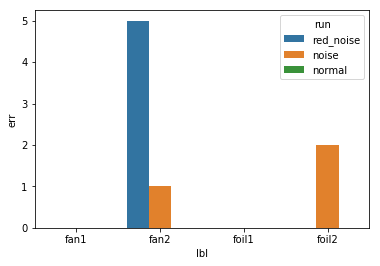

In [212]:
sns.barplot(x="lbl", y="err", hue="run", data=df_err)

## Start getting the confidence intervals

In [124]:
ReactResult = namedtuple("ReactResult", ["output", "noise", "reduce"])

In [127]:
fast_res = []

for fi in glob.glob("../data/fast_react_*"):
    with h5py.File(fi, "r") as h_fi:
        fast_res.append(
            ReactResult(np.array(h_fi['clean_out']), h_fi['clean_out'].attrs["noise"], h_fi['clean_out'].attrs["reduce"]))

In [191]:
react_res = []

for fi in glob.glob("../data/actual_react_explore*"):
    with h5py.File(fi, "r") as h_fi:
        react_res.append(
            ReactResult(np.array(h_fi['clean_out']), h_fi['clean_out'].attrs["noise"], h_fi['clean_out'].attrs["reduce"]))

In [196]:
df_list = []
err_list = []

for res in react_res:
    if res.noise == 0.9:
        continue
    decs = []
    t_decs = []

    for t_slice in all_time_slices:
        cl_slc = res.output[t_slice+td_pause:t_slice+td_each]
        tm, dec = decision(cl_slc, thresh=thresh, dec_thresh=dec_thresh)
        decs.append(dec)
        t_decs.append(tm)

    decs = np.array(decs)
    t_decs = np.array(t_decs)
    df_list.append(pd.DataFrame.from_dict({"t_decs": t_decs,
                                           "lbl": match_labels,
                                           "reduce": [res.reduce]*len(t_decs),
                                           "noise": [res.noise]*len(t_decs)}))
    
    last_idx = 0
    for lst, lbl in zip((fan1, fan2, foil1, foil2), ("fan1", "fan2", "foil1", "foil2")):
        comp_slc = slice(last_idx, last_idx+len(lst))
        err_list.append((res.reduce, res.noise, np.sum(decs[comp_slc] != match_correct[comp_slc]), lbl))
        last_idx += len(lst)

df_match = pd.concat(df_list)
df_err = pd.DataFrame(err_list, columns=("reduce", "noise", "err", "lbl"))

In [197]:
reds = list(df_err.reduce.unique())
reds.sort()

noises = list(df_err.noise.unique())
noises.sort()

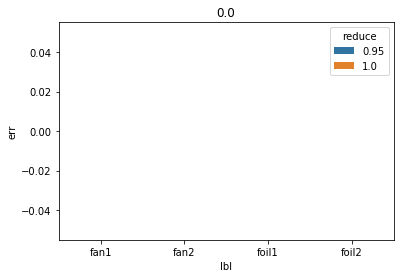

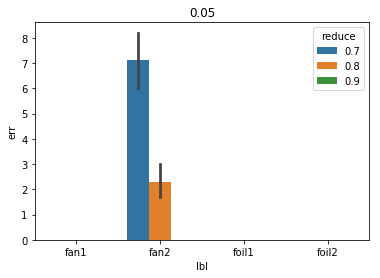

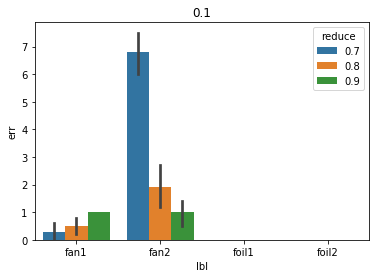

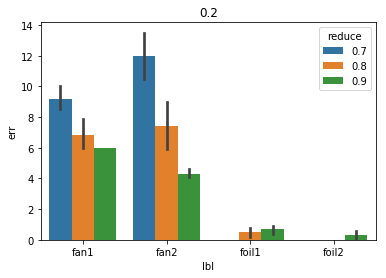

In [198]:
for noise in noises:
    plt.figure()
    ax = sns.barplot(x="lbl", y="err", hue="reduce", data=df_err[df_err.noise == noise])
    ax.set_title(noise)

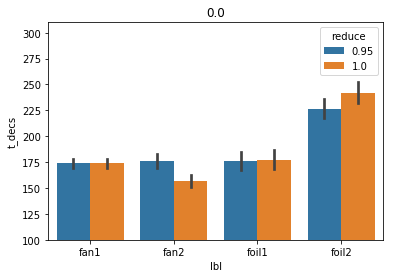

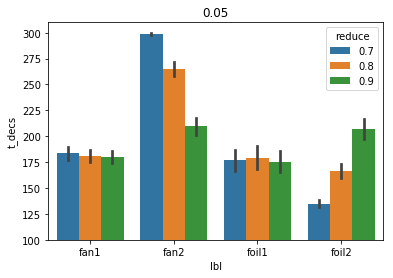

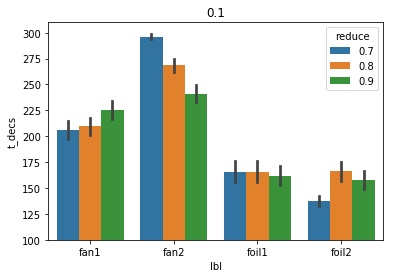

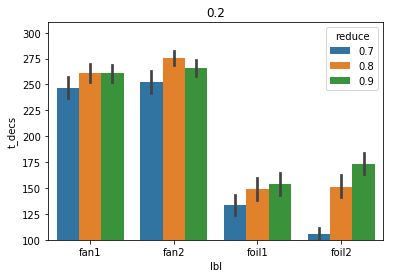

In [199]:
for noise in noises:
    plt.figure()
    ax = sns.barplot(x="lbl", y="t_decs", hue="reduce", data=df_match[df_match.noise == noise])
    ax.set_title(noise)
    ax.set_ylim((100, 310))

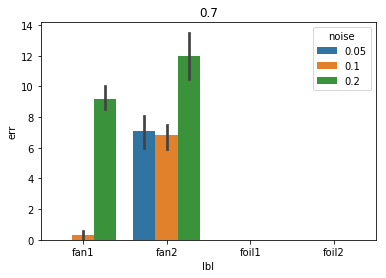

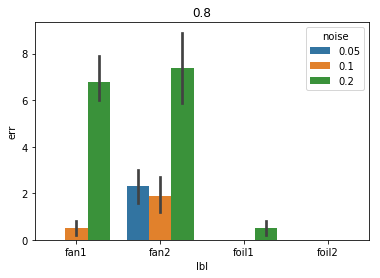

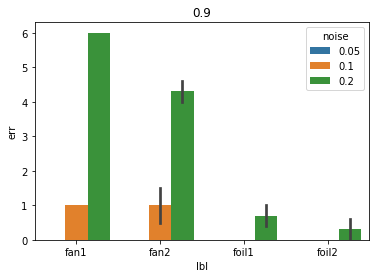

In [172]:
for red in reds:
    plt.figure()
    ax = sns.barplot(x="lbl", y="err", hue="noise", data=df_err[df_err.reduce == red])
    ax.set_title(red)

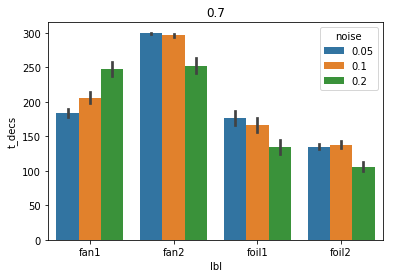

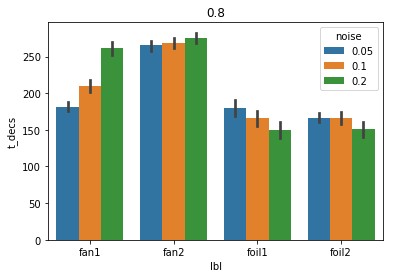

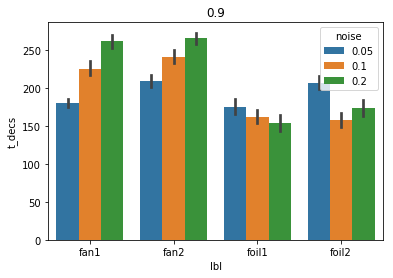

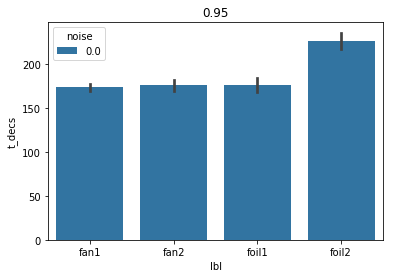

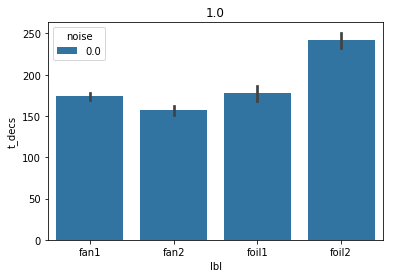

In [200]:
for red in reds:
    plt.figure()
    ax = sns.barplot(x="lbl", y="t_decs", hue="noise", data=df_match[df_match.reduce == red])
    ax.set_title(red)

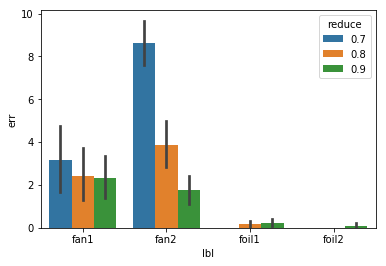

In [165]:
ax = sns.barplot(x="lbl", y="err", hue="reduce", data=df_err)

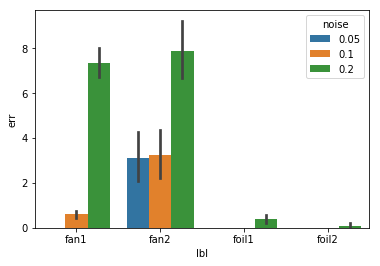

In [173]:
ax = sns.barplot(x="lbl", y="err", hue="noise", data=df_err)

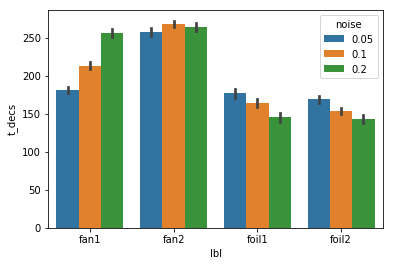

In [162]:
sns.barplot(x="lbl", y="t_decs", hue="noise", data=df_match)

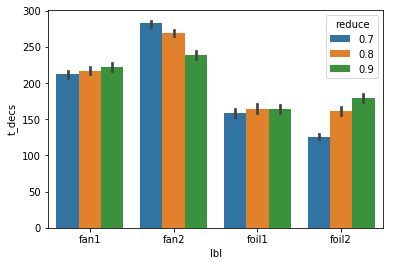

In [169]:
sns.barplot(x="lbl", y="t_decs", hue="reduce", data=df_match)

In [141]:
df_list = []
err_list = []

for res in fast_res:
    decs = []
    t_decs = []

    for t_slice in all_time_slices:
        cl_slc = res.output[t_slice+td_pause:t_slice+td_each]
        tm, dec = decision(cl_slc, thresh=thresh, dec_thresh=dec_thresh)
        decs.append(dec)
        t_decs.append(tm)

    decs = np.array(decs)
    t_decs = np.array(t_decs)
    df_list.append(pd.DataFrame.from_dict({"t_decs": t_decs,
                                           "lbl": match_labels,
                                           "cor": match_correct,
                                           "reduce": [res.reduce]*len(t_decs),
                                           "noise": [res.noise]*len(t_decs)}))
    
    last_idx = 0
    for lst, lbl in zip((fan1, fan2, foil1, foil2), ("fan1", "fan2", "foil1", "foil2")):
        comp_slc = slice(last_idx, last_idx+len(lst))
        err_list.append((res.reduce, res.noise, np.sum(decs[comp_slc] != match_correct[comp_slc]), lbl))
        last_idx += len(lst)

df_match = pd.concat(df_list)
df_err = pd.DataFrame(err_list, columns=("reduce", "noise", "err", "lbl"))

In [178]:
ComplexReactResult = namedtuple("ComplexReactResult", ["output", "f1_noise", "f1_reduce", "f2_noise", "f2_reduce"])

In [187]:
comp_res = []

for fi in glob.glob("../data/more_react_explore*"):
    with h5py.File(fi, "r") as h_fi:
        comp_res.append(
            ComplexReactResult(np.array(h_fi['clean_out']),
                        h_fi['clean_out'].attrs["fan1_noise"], h_fi['clean_out'].attrs["fan1_reduce"],
                        h_fi['clean_out'].attrs["fan1_noise"], h_fi['clean_out'].attrs["fan1_reduce"]))

In [189]:
df_list = []
err_list = []

for res in comp_res:
    decs = []
    t_decs = []

    for t_slice in all_time_slices:
        cl_slc = res.output[t_slice+td_pause:t_slice+td_each]
        tm, dec = decision(cl_slc, thresh=thresh, dec_thresh=dec_thresh)
        decs.append(dec)
        t_decs.append(tm)

    decs = np.array(decs)
    t_decs = np.array(t_decs)
    df_list.append(pd.DataFrame.from_dict({"t_decs": t_decs,
                                           "lbl": match_labels,
                                           "f1_reduce": [res.f1_reduce]*len(t_decs),
                                           "f1_noise": [res.f1_noise]*len(t_decs),
                                           "f2_reduce": [res.f2_reduce]*len(t_decs),
                                           "f2_noise": [res.f2_noise]*len(t_decs)}))
    
    last_idx = 0
    for lst, lbl in zip((fan1, fan2, foil1, foil2), ("fan1", "fan2", "foil1", "foil2")):
        comp_slc = slice(last_idx, last_idx+len(lst))
        err_list.append((res.f1_reduce, res.f1_noise, res.f2_reduce, res.f2_noise,
                         np.sum(decs[comp_slc] != match_correct[comp_slc]), lbl))
        last_idx += len(lst)

df_match = pd.concat(df_list)
df_err = pd.DataFrame(err_list, columns=("f1_reduce", "f1_noise", "f2_reduce", "f2_noise", "err", "lbl"))